In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
import seaborn as sns
import re

# Load data

## for barcode, feature, matrix file.

In [3]:
# barcode, feature, matrix 파일을 읽어서 AnnData 객체로 바꾼 후 adata_list에 저장.
import glob
import shutil
def read_10x_mtx_multiple(directory):
    # matrix, barcodes, features 파일 검색
    matrix_files = glob.glob(os.path.join(directory, '*matrix.mtx.gz'))
    barcode_files = glob.glob(os.path.join(directory, '*barcodes.tsv.gz'))
    feature_files = glob.glob(os.path.join(directory, '*features.tsv.gz'))
    feature_files += glob.glob(os.path.join(directory, '*genes.tsv.gz'))
    
    adata_list = []
    # print(matrix_files)
    
    for matrix_file in matrix_files:
        # 파일 이름에서 base_name (공통 이름) 추출
        base_name = os.path.basename(matrix_file).split('matrix')[0]
        
        # base_name 으로 barcodes, features (genes) 파일 찾기
        barcode_file = [bf for bf in barcode_files if base_name in bf]
        feature_file = [ff for ff in feature_files if base_name in ff]
        print(matrix_file, barcode_file, feature_file)
        
        if len(barcode_file) == 1 and len(feature_file) == 1:   # 만약 barcode, feature 파일이 하나씩 있는 경우
            matrix_dir = os.path.dirname(matrix_file)
            
            # 임시 디렉토리 생성 및 파일 복사
            temp_dir = os.path.join(directory, base_name + '_temp')
            os.makedirs(temp_dir, exist_ok=True)
            
            shutil.copy(matrix_file, os.path.join(temp_dir, 'matrix.mtx.gz'))
            shutil.copy(barcode_file[0], os.path.join(temp_dir, 'barcodes.tsv.gz'))
            
            if 'features' in feature_file[0]:   # features.tsv.gz 파일인 경우
                # shutil.copy(feature_file[0], os.path.join(temp_dir, 'features.tsv.gz'))
                features = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                if features.shape[1] == 1: # gene name column만 있는 경우
                    features['gene_id'] = features[0]
                    features['feature_type'] = 'Gene Expression'
                    features = features[[0, 'gene_id', 'feature_type']]
                features.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            else:   # genes.tsv.gz 파일인 경우 (type column이 없이 gene ID, gene name만 있는 경우)
                # genes.tsv.gz 파일을 features.tsv.gz 형식으로 변환
                genes = pd.read_csv(feature_file[0], header = None, sep = '\t', compression = 'gzip')
                genes['type'] = 'Gene Expression'
                genes.to_csv(os.path.join(temp_dir, 'features.tsv.gz'), header = False, index = False, sep = '\t', compression = 'gzip')
            
            # read data
            adata = sc.read_10x_mtx(
                path = temp_dir,
                var_names = 'gene_symbols',
                make_unique = True
            )
            adata.var_names_make_unique()   # gene 이름 중복 제거
            adata.obs['sample'] = base_name # sample 열 추가
            adata.obs['sample'] = adata.obs['sample'].apply(lambda x: re.search(r'_(.*?)_', x).group(1)) # 파일 이름에서 _와 _ 사이의 문자열 추출
            
            # 임시 디렉토리 및 파일 삭제
            shutil.rmtree(temp_dir)
            
            adata_list.append(adata)
        else:   # 파일이 없거나 여러개인 경우
            print(f"Could not find matching barcode of feature file for {base_name}")
            
    return adata_list

In [12]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2/"
adata_list = read_10x_mtx_multiple(folder_path)

adata_list
# 40s for 24 samples
# 1m 39s for 104 samples

C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\GSM5319503_SF10099_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319503_SF10099_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319503_SF10099_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\GSM5319504_SF10432_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319504_SF10432_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319504_SF10432_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\GSM5319505_SF10857_matrix.mtx.gz ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319505_SF10857_barcodes.tsv.gz'] ['C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2\\GSM5319505_SF10857_features.tsv.gz']
C:/Users/heung/OneDrive/Documents/scData/16. Sigl

[AnnData object with n_obs × n_vars = 568 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 994 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2624 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 4134 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5783 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1300 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 6686 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3705 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1332 × 33694
     obs: 'sample'
     var: 'gene_ids', 'feature_types',
 AnnData object with 

In [13]:
len(adata_list)

80

## for .h5 file
> 작동 안할 확률 있음\
> 뒤의 코드와 안맞을 확률 있음

In [ ]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/13. aPD-1 Fcgr2b for scanpy test/aPD-1_analysis/"
adata_list = []

# Load all datas in the control folder
for filename in os.listdir(folder_path + 'control/'):
    file_path = os.path.join(folder_path + 'control/', filename)
    
    if filename.endswith(".h5"):                # Check if the file is a 10x data
        adata = sc.read_10x_h5(file_path)       # Read the 10x data
        adata.obs['sample_type'] = 'control'    # Add the sample type to the metadata
        adata.var_names_make_unique()           # Make the gene names unique
        adata_list.append(adata)                    # Append the data to the list

# load all datas in the treatment folder
for filename in os.listdir(folder_path + 'treated/'):
    file_path = os.path.join(folder_path + 'treated/', filename)
    
    if filename.endswith(".h5"):                # Check if the file is a 10x data
        adata = sc.read_10x_h5(file_path)       # Read the 10x data
        adata.obs['sample_type'] = 'treatment'      # Add the sample type to the metadata
        adata.var_names_make_unique()           # Make the gene names unique
        adata_list.append(adata)                    # Append the data to the list

# delete the variable to save memory
del file_path, filename, folder_path, adata



# Basic filtering

In [14]:
for adata in adata_list:
    sc.pp.filter_cells(adata, min_genes = 20)
adata_list

[AnnData object with n_obs × n_vars = 568 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 994 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2624 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 4134 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 5783 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1300 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 6686 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3705 × 33694
     obs: 'sample', 'n_genes'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1332

# n_count_RNa, n_count_feature, pct_mt filtering

In [15]:
# list of ribosommal genes
# for mouse genes
# ribo_url = 'https://www.gsea-msigdb.org/gsea/msigdb/mouse/download_geneset.jsp?geneSetName=GOCC_RIBOSOME&fileType=gmt'
# ribo_genes = pd.read_table(ribo_url, sep = '\t', header = None).transpose().drop([0, 1])

# for human genes
ribo_url = 'http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt'
ribo_genes = pd.read_table(ribo_url, skiprows = 2, header = None)

del ribo_url

In [16]:
# Calculate QC metrics
for adata in adata_list:
    adata.var['mito'] = adata.var_names.str.startswith('MT-')   # 'mt-' for mouse, 'MT-' for human  # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

adata_list
del ribo_genes

In [17]:
adata_list[1].obs.head(5)

,sample,n_genes,n_genes_by_counts,total_counts,pct_counts_mito,pct_counts_ribo
AAACCCACAAGCTGCC-1,SF10432,165,165,178.0,0.000000,0.000000
AAACCCACACTAAACC-1,SF10432,107,107,112.0,0.000000,0.892857
AAACGAAAGAGCCGAT-1,SF10432,450,450,501.0,0.199601,0.000000
AAACGAATCTGACCCT-1,SF10432,176,176,206.0,0.000000,0.000000
AAACGCTAGGACTAAT-1,SF10432,127,127,136.0,0.000000,0.000000


In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Violin plot of the cell quality
for adata in adata_list:
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
        jitter = 0.4,
        multi_panel = True
    )

In [ ]:
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [18]:
# Filter the data
for i in range(len(adata_list)):
    cutoff_top = np.quantile(adata_list[i].obs.n_genes_by_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.n_genes_by_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.total_counts.values, .95)
    adata_list[i] = adata_list[i][adata_list[i].obs.total_counts < cutoff_top]
    
    cutoff_top = np.quantile(adata_list[i].obs.pct_counts_mito.values, .90)
    adata_list[i] = adata_list[i][adata_list[i].obs.pct_counts_mito < cutoff_top]

adata_list
del cutoff_top, i

In [ ]:
# Histogram of the cell quality
for adata in adata_list:
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    
    ax[2].hist(adata.obs.pct_counts_mito, bins = n_bins)
    ax[2].set_title("pct_counts_mito")
    
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    

    plt.tight_layout()
    plt.show
    del fig, ax, n_bins

In [ ]:
# Violin plot of the cell quality
for adata in adata_list:
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'],
        jitter = 0.4,
        multi_panel = True
    )

In [ ]:
rcParams['figure.figsize'] = 4, 4 # width, height

for adata in adata_list:
    sc.pl.scatter(
        adata,
        x = 'total_counts',
        y = 'n_genes_by_counts',
        color = 'pct_counts_mito',
    )

In [19]:
# 세포가 1개 이상인 샘플만 남기기
adata_list = [adata for adata in adata_list if adata.n_obs > 0]
len(adata_list)

70

In [20]:
# 각 adata의 n_obs 값을 확인하고, 그 중 최솟값을 구함
n_obs_list = [adata.n_obs for adata in adata_list]
min_n_obs = min(n_obs_list)

print(f"The minimum n_obs in adata_list is {min_n_obs}.")

The minimum n_obs in adata_list is 153.


# Doublet removal
> **scVI SOLO와 Scrublet 두 방식 <- 둘 중 하나만 쓰면 됨**

## By scVI SOLO
> (아마) 좋은거 같긴 한데 개느림\
> 아래 코드 돌아가는지도 잘 모르겠음. 돌리는데 오래걸려서 체크 안함\

In [ ]:
# import torch

# check if the GPU is available
# torch.cuda.get_device_name(0)

In [ ]:
import scvi

# doublet detection function using scvi and solo models
def doublet_detection(adata):
    # train the scvi model
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    
    # train the solo model
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    
    # predict the doublet score
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    # df.index = df.index.map(lambda x: x[:-2])                         # not required if use adata.copy()
    df['dif'] = df.doublet - df.singlet
    
    return adata, df

In [ ]:
# doublet detection
for i in range(len(adata_list)):
    adata_list[i], df = doublet_detection(adata_list[i].copy())                 # doublet detection
    print(df.groupby('prediction').count())                             # print the number of predicted doublets and singlets
    
    sns.displot(df[df.prediction == 'doublet'], x = 'dif')              # plot the doublet score distribution
    
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]          # df.dif cutoff는 적당히 설정
    adata_list[i].obs['doublet'] = adata_list[i].obs.index.isin(doublets.index) # add the doublet information to the obs
    
    adata_list[i] = adata_list[i][~adata_list[i].obs.doublet]                       # remove the doublets from the data
    
# ~6.25 min per sample

## By Scrublet 
> 빨라서 씀. SOLO보다 doublet을 더 적게 detection함\
> 약 37k cells 돌리는데 16초\
> 제대로 되는건 맞는지 잘 모름

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


c:\Users\heung\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 39.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.1%
Elapsed time: 0.3 seconds
Processed adata 1/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Error in processing adata 2/70: n_components=30 must be strictly less than min(n_samples, n_features)=30 with svd_solver='arpack'
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 0.8 seconds
Processed adata 3/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 34.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 2.0 seconds
Processed adata 4/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 53.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 2.7 seconds
Processed adata 5/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 21.4%
Elapsed time: 7.1 seconds
Processed adata 6/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 1.1 seconds
Processed adata 7/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 5.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.3%
Elapsed time: 0.2 seconds
Processed adata 8/70 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.12
Detected doublet rate = 47.0%
Estimated detectable doublet fraction = 84.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 55.7%
Elapsed time: 0.3 seconds
Processed adata 9/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 12.3%
Estimated detectable doublet fraction = 35.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 34.5%
Elapsed time: 0.1 seconds
Processed adata 10/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 16.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.8%
Elapsed time: 0.1 seconds


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Processed adata 11/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 6.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 0.3 seconds
Processed adata 12/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 10.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 23.1%
Elapsed time: 0.1 seconds
Processed adata 13/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 22.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 1.0 seconds
Processed adata 14/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 24.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 0.7 seconds
Processed adata 15/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 30.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.9%
Elapsed time: 0.8 seconds
Processed adata 16/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 38.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.3%
Elapsed time: 8.5 seconds
Processed adata 17/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 14.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.4%
Elapsed time: 0.1 seconds
Processed adata 18/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 9.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.0%
Elapsed time: 0.2 seconds
Processed adata 19/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 120.0%
Elapsed time: 0.1 seconds
Processed adata 20/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 34.0%
Elapsed time: 0.2 seconds
Processed adata 21/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 9.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 1.0 seconds
Processed adata 22/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Error in processing adata 23/70: n_components=30 must be between 1 and min(n_samples, n_features)=28 with svd_solver='arpack'
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 24.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.8%
Elapsed time: 0.0 seconds
Processed adata 24/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
c:\Users\heung\anaconda3\Lib\site-packages\scrublet\scrublet.py:485: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize = fig_size)
C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])
C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify 

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 4.5%
Estimated detectable doublet fraction = 42.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.5%
Elapsed time: 0.5 seconds
Processed adata 25/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 31.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.1%
Elapsed time: 1.6 seconds
Processed adata 26/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.04
Detected doublet rate = 76.8%
Estimated detectable doublet fraction = 96.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 79.3%
Elapsed time: 2.1 seconds
Processed adata 27/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 53.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 2.3 seconds
Processed adata 28/70 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 44.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 0.2 seconds
Processed adata 29/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 32.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.1%
Elapsed time: 1.0 seconds
Processed adata 30/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 10.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 1.3 seconds
Processed adata 31/70 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 29.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.5%
Elapsed time: 0.4 seconds
Processed adata 32/70 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 34.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.9%
Elapsed time: 0.4 seconds
Processed adata 33/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 37.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.5%
Elapsed time: 0.3 seconds
Processed adata 34/70 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 48.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.5%
Elapsed time: 0.6 seconds
Processed adata 35/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 48.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.2%
Elapsed time: 0.7 seconds


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Processed adata 36/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 60.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 1.8 seconds
Processed adata 37/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 25.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 1.0 seconds
Processed adata 38/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 26.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.8%
Elapsed time: 0.8 seconds
Processed adata 39/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 56.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.4%
Elapsed time: 2.7 seconds
Processed adata 40/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 53.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.5%
Elapsed time: 2.0 seconds
Processed adata 41/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.10
Detected doublet rate = 38.7%
Estimated detectable doublet fraction = 87.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 44.1%
Elapsed time: 6.8 seconds
Processed adata 42/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 31.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.7%
Elapsed time: 1.4 seconds
Processed adata 43/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Error in processing adata 44/70: n_components=30 must be between 1 and min(n_samples, n_features)=18 with svd_solver='arpack'
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores
C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 21.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 1.2 seconds
Processed adata 45/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 43.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.0%
Elapsed time: 4.5 seconds
Processed adata 46/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 16.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 2.9 seconds
Processed adata 47/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.68
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.9%
Elapsed time: 2.0 seconds
Processed adata 48/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 32.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.9%
Elapsed time: 2.1 seconds
Processed adata 49/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Elapsed time: 1.7 seconds
Processed adata 50/70 successfully.
Error in processing adata 50/70: 'Scrublet' object has no attribute 'threshold_'
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.7%
Elapsed time: 0.3 seconds
Processed adata 51/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 13.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 1.0 seconds
Processed adata 52/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 53.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 0.9 seconds
Processed adata 53/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 57.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 1.1 seconds
Processed adata 54/70 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 31.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.8%
Elapsed time: 0.7 seconds
Processed adata 55/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 10.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.4%
Elapsed time: 1.9 seconds
Processed adata 56/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 35.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.3%
Elapsed time: 0.9 seconds
Processed adata 57/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 2.9%
Estimated detectable doublet fraction = 52.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.6%
Elapsed time: 0.4 seconds
Processed adata 58/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 56.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.8%
Elapsed time: 2.9 seconds
Processed adata 59/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 17.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 0.3 seconds
Processed adata 60/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 42.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.5%
Elapsed time: 0.6 seconds
Processed adata 61/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.8%
Elapsed time: 1.7 seconds
Processed adata 62/70 successfully.
Preprocessing...
Simulating doublets...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 100.0%
Elapsed time: 0.8 seconds
Processed adata 63/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 1.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 21.8%
Elapsed time: 1.6 seconds
Processed adata 64/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 4.2%
Estimated detectable doublet fraction = 53.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.0%
Elapsed time: 0.9 seconds
Processed adata 65/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 46.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 1.9 seconds
Processed adata 66/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 45.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.3%
Elapsed time: 2.6 seconds
Processed adata 67/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 31.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 0.4 seconds
Processed adata 68/70 successfully.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 4.6%
Estimated detectable doublet fraction = 6.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 66.7%
Elapsed time: 0.2 seconds
Processed adata 69/70 successfully.
Preprocessing...


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 48.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 2.6 seconds
Processed adata 70/70 successfully.


C:\Users\heung\AppData\Local\Temp\ipykernel_34372\1151810679.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_scores'] = doublet_scores


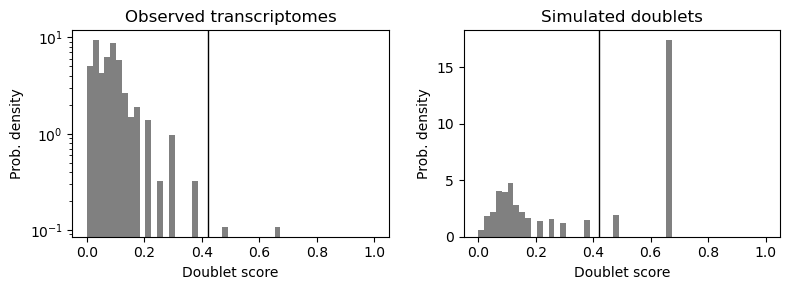

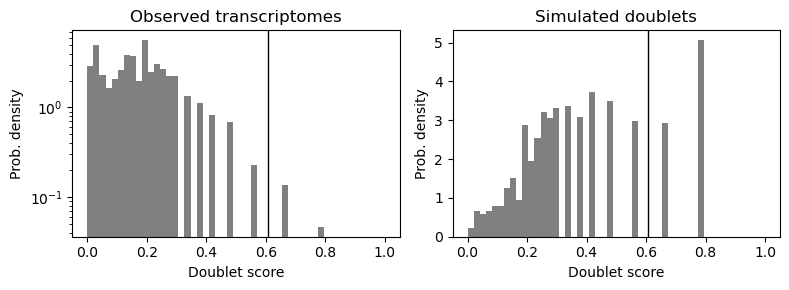

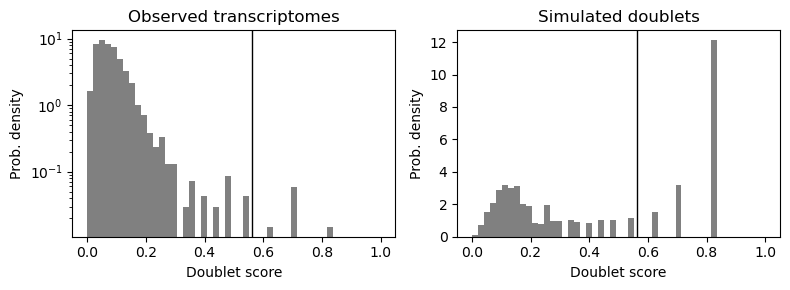

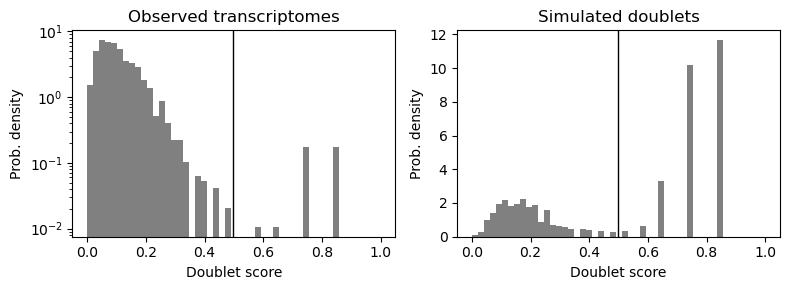

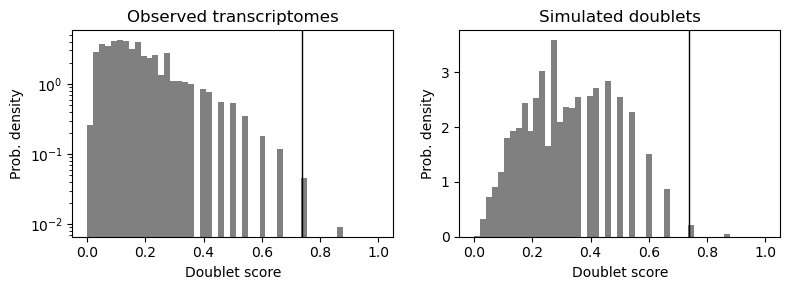

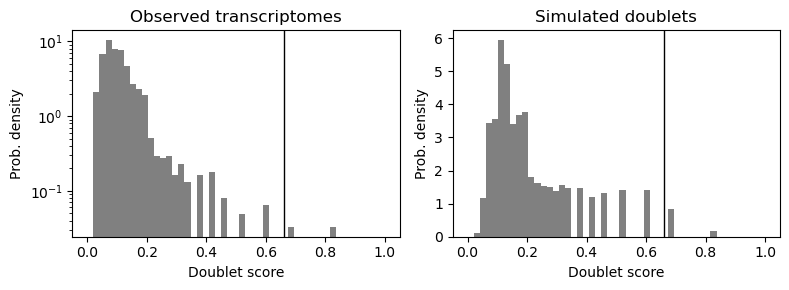

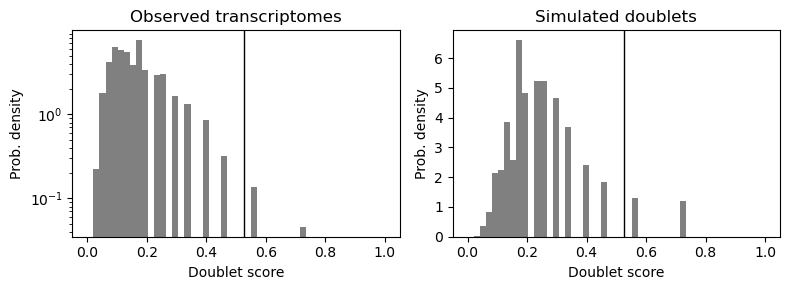

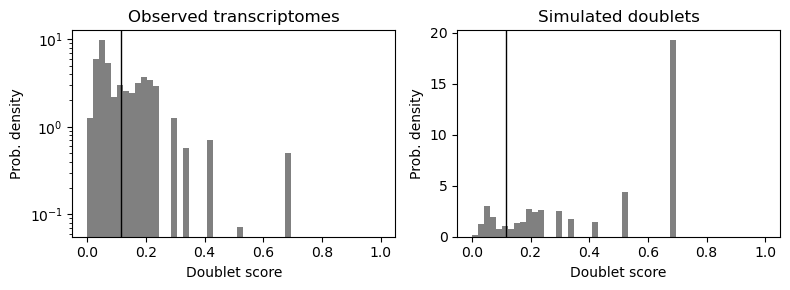

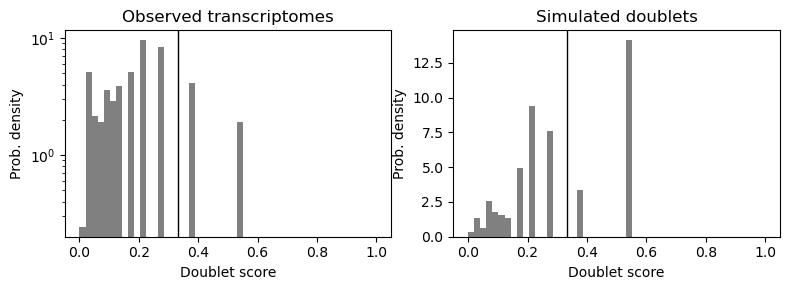

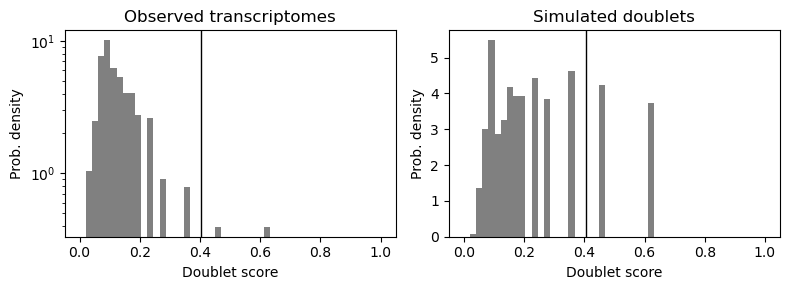

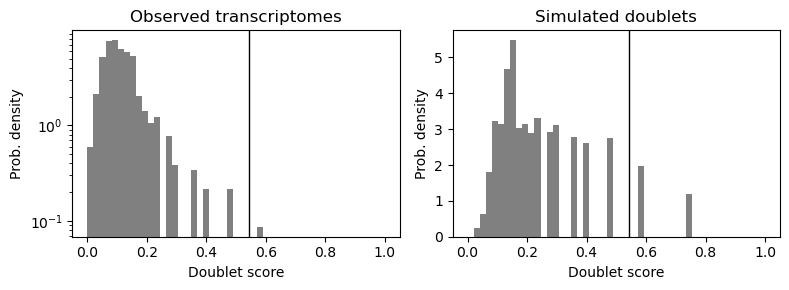

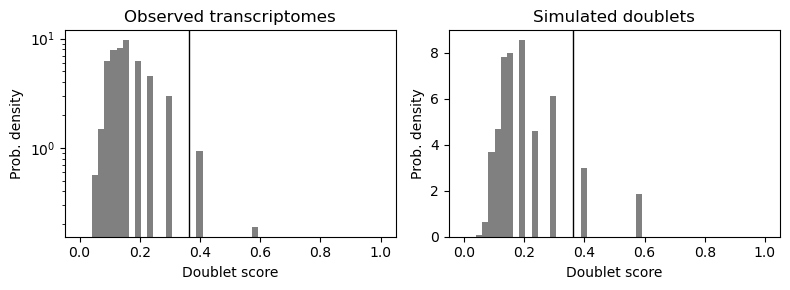

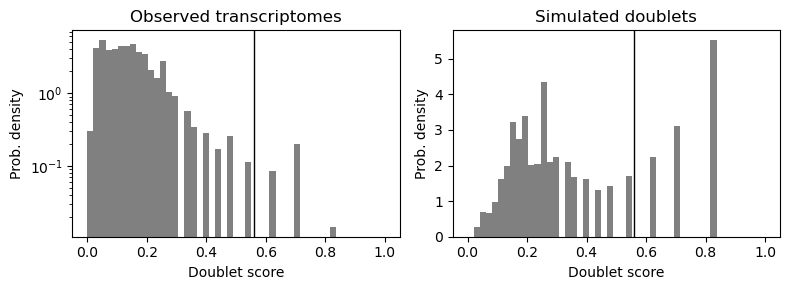

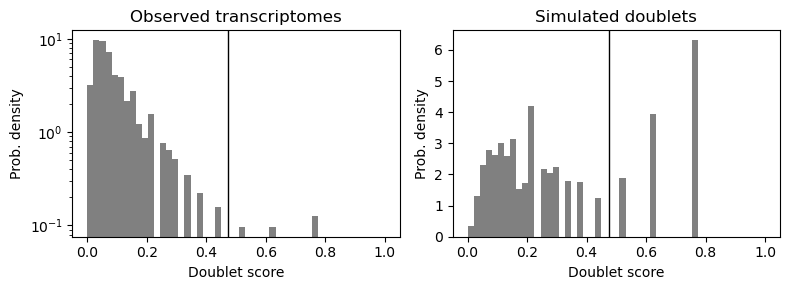

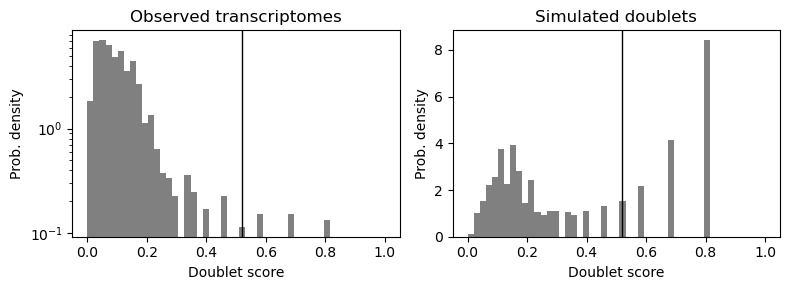

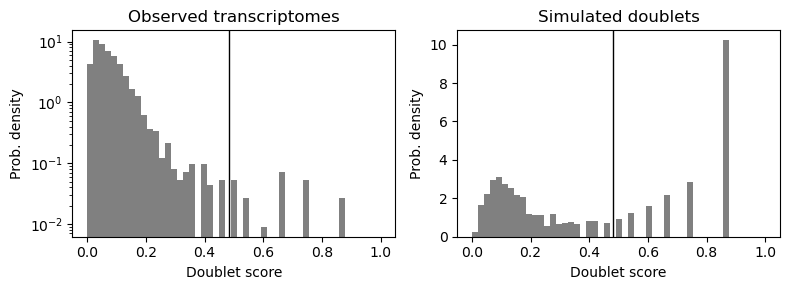

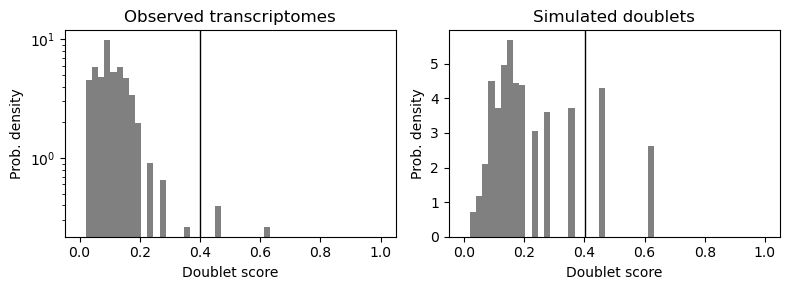

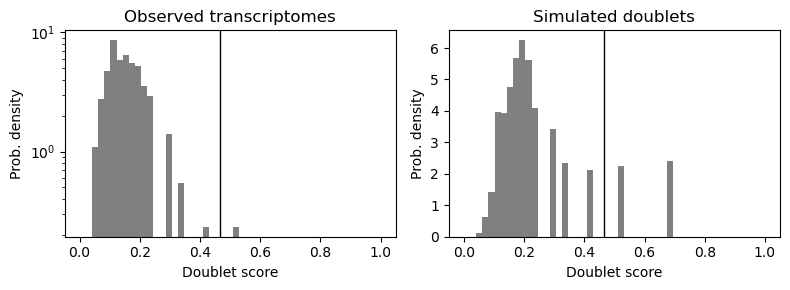

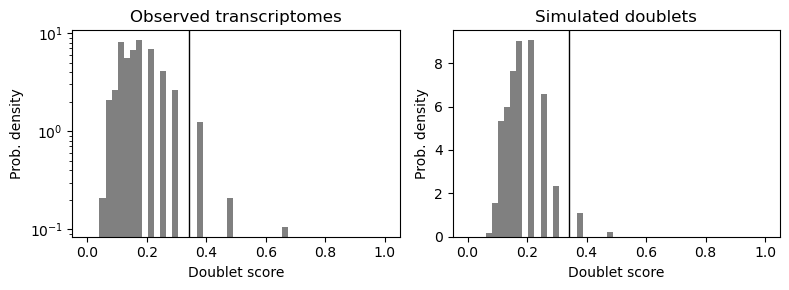

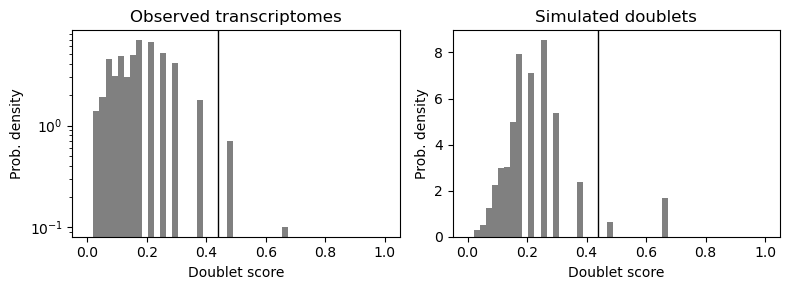

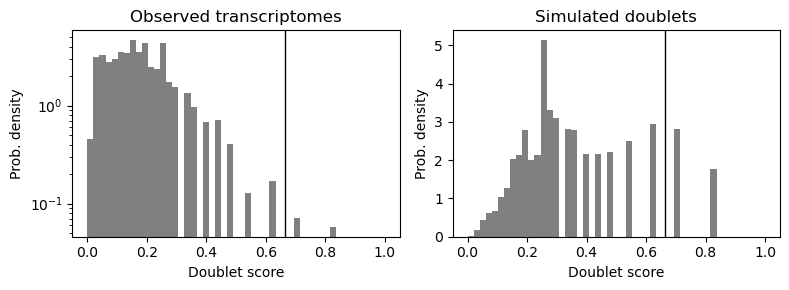

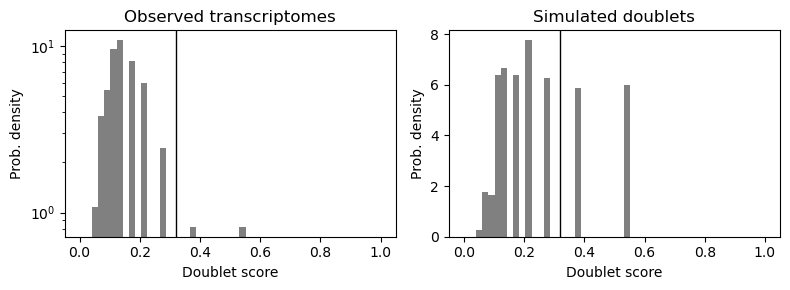

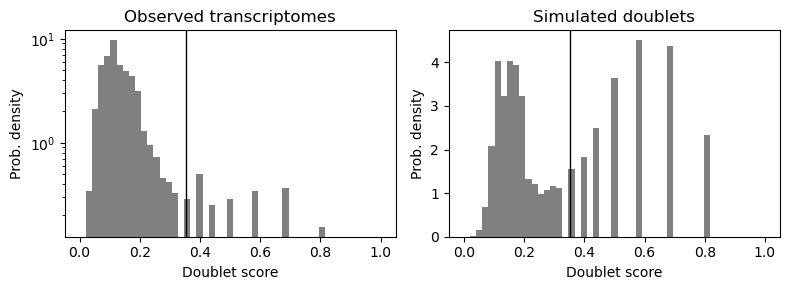

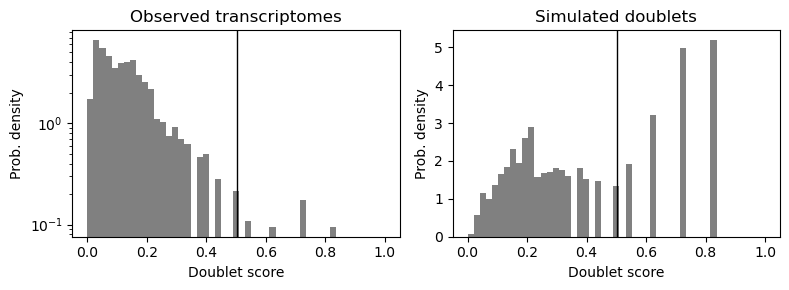

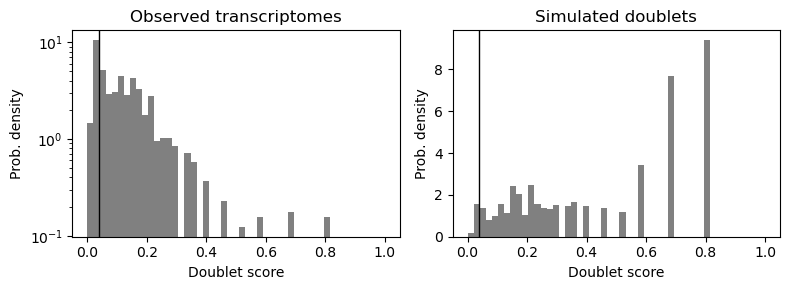

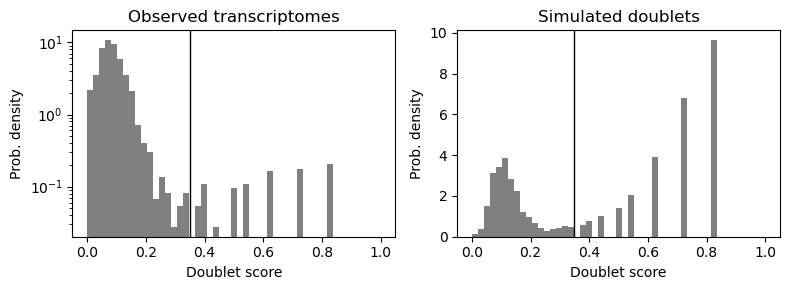

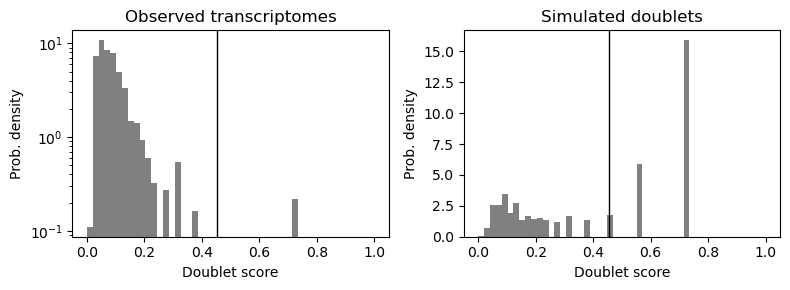

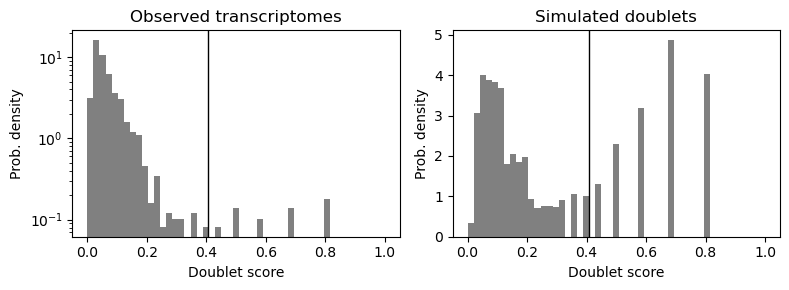

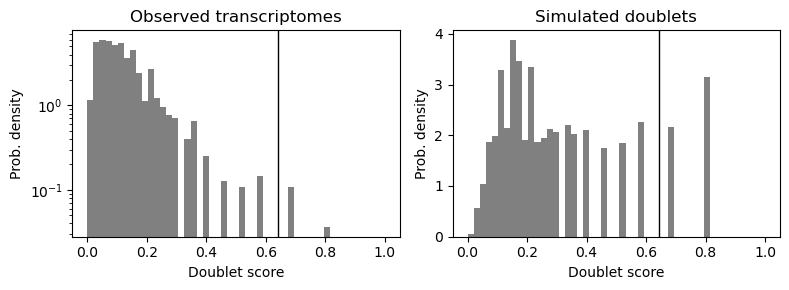

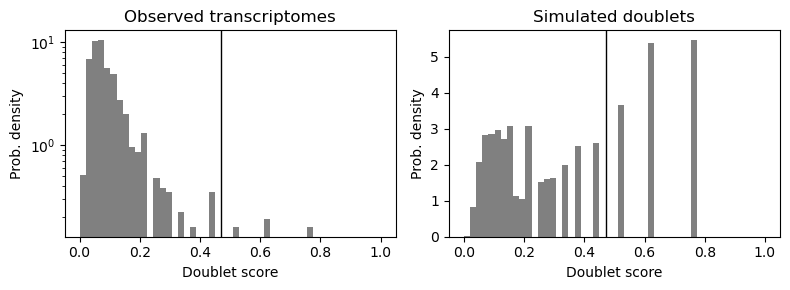

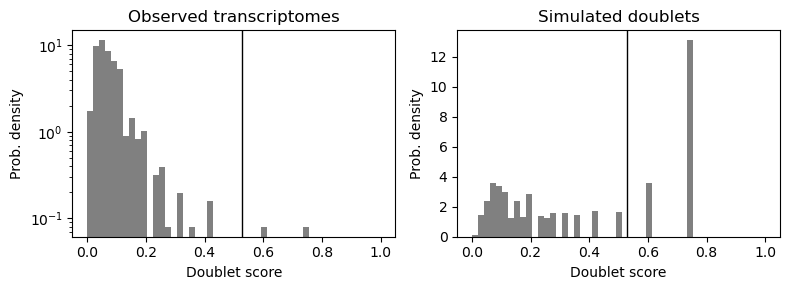

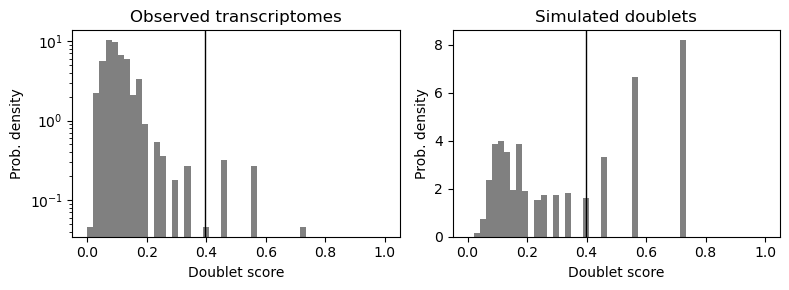

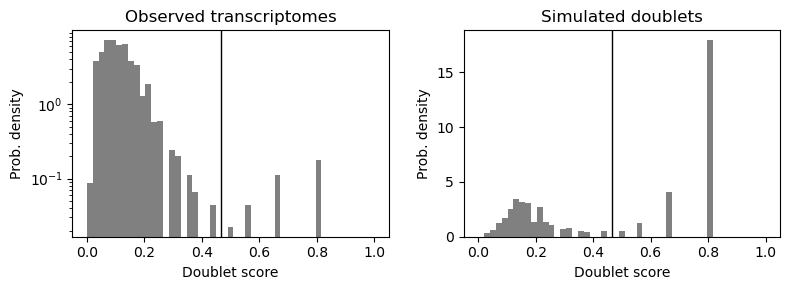

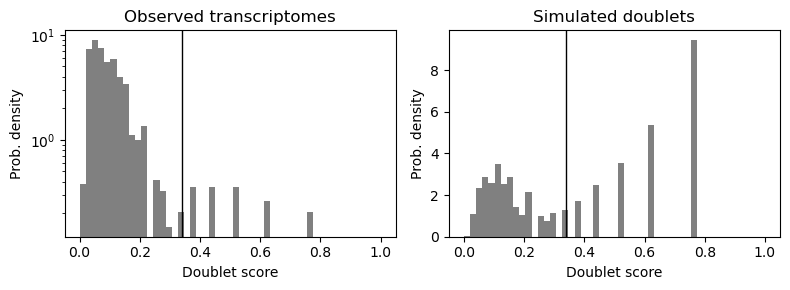

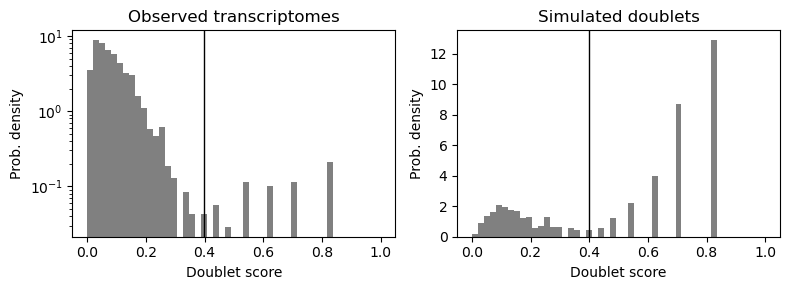

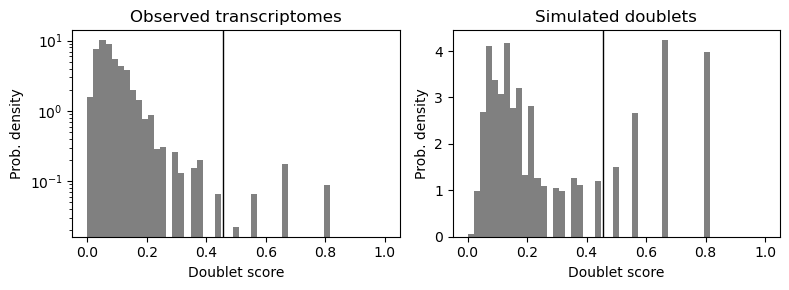

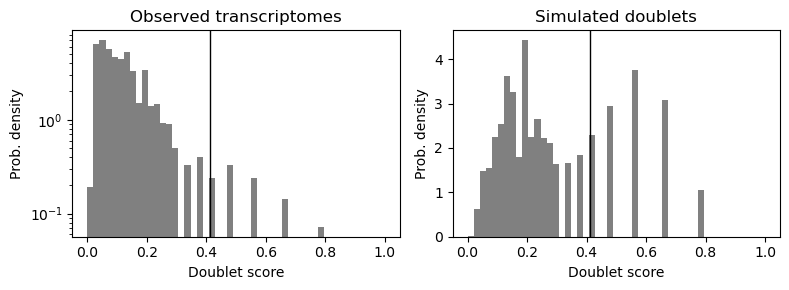

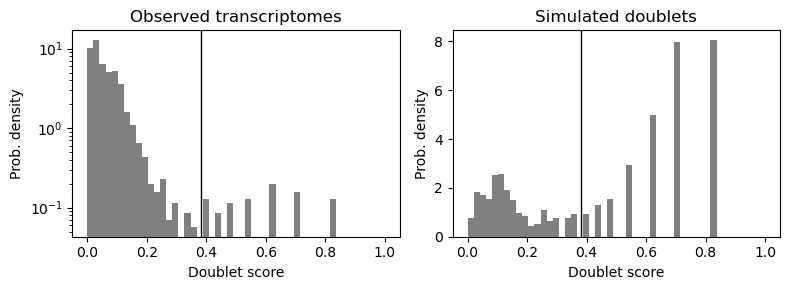

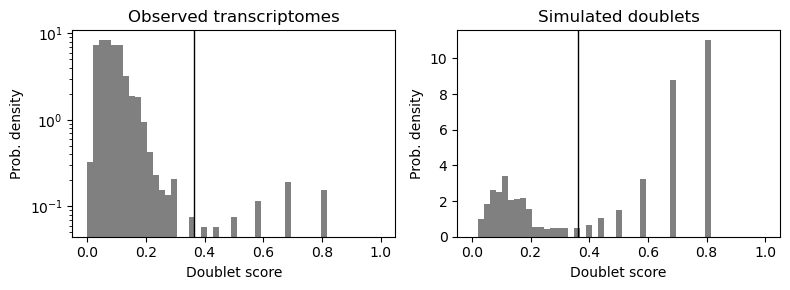

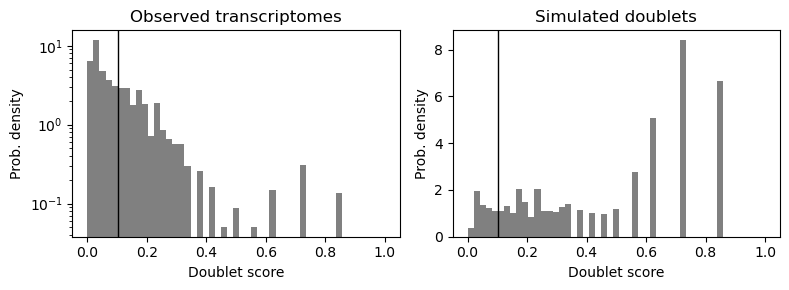

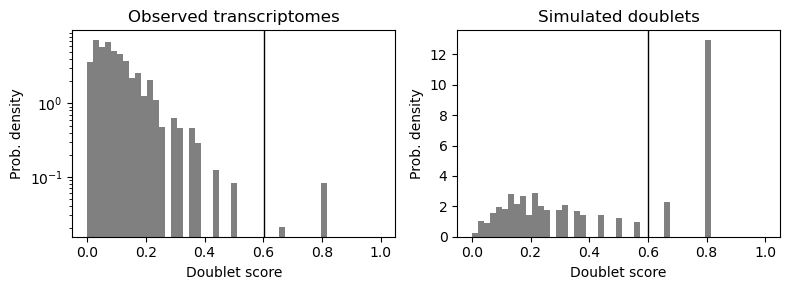

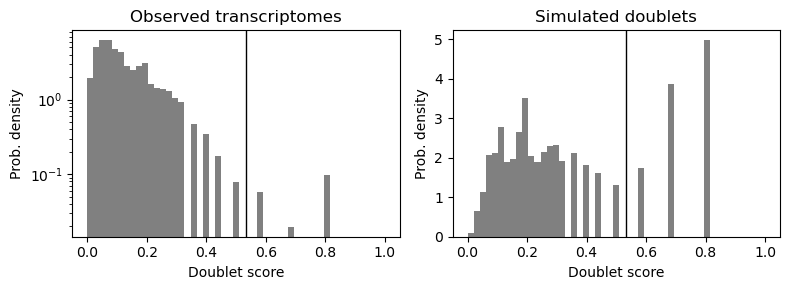

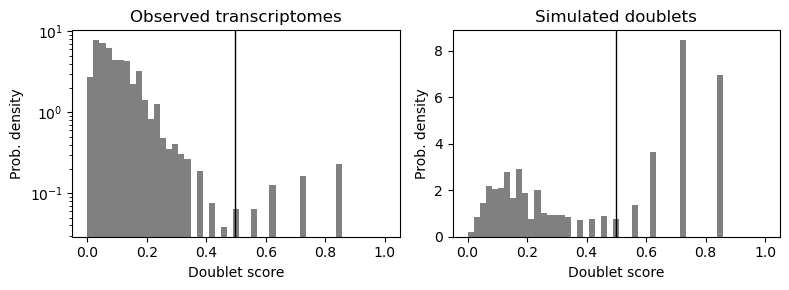

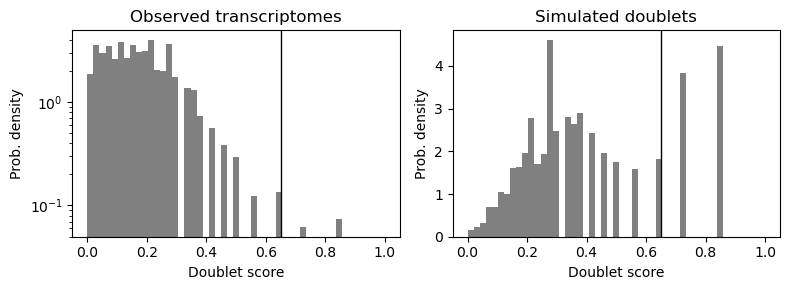

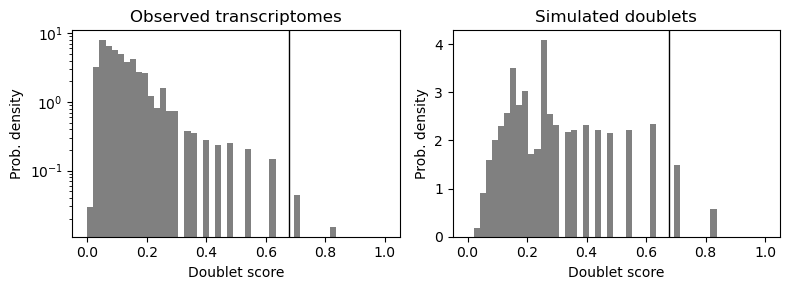

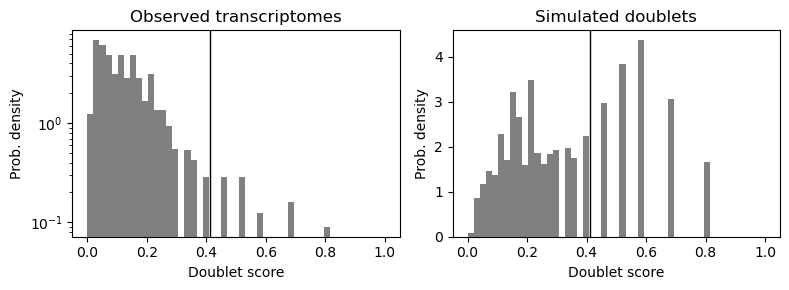

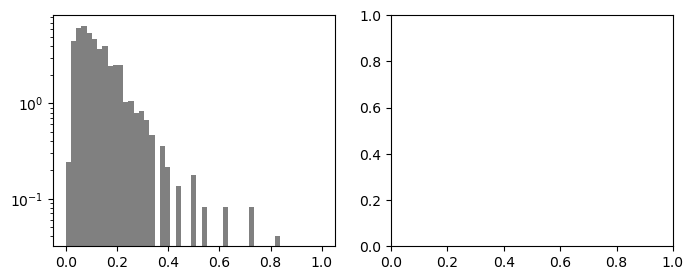

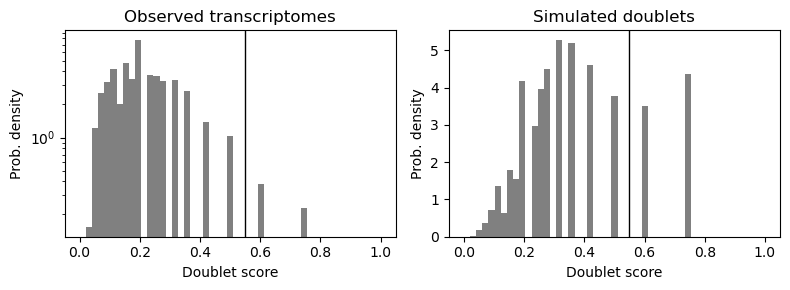

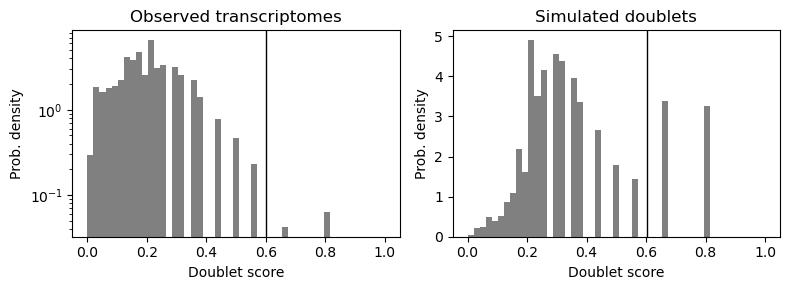

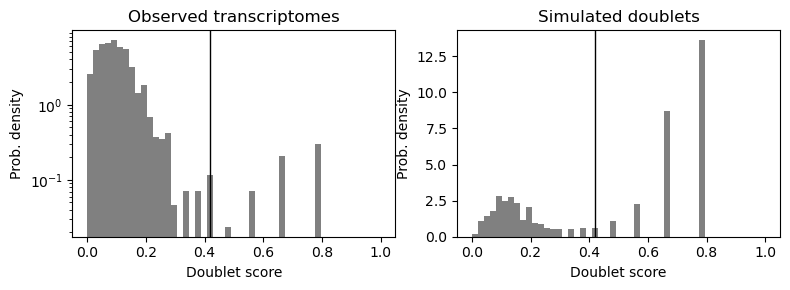

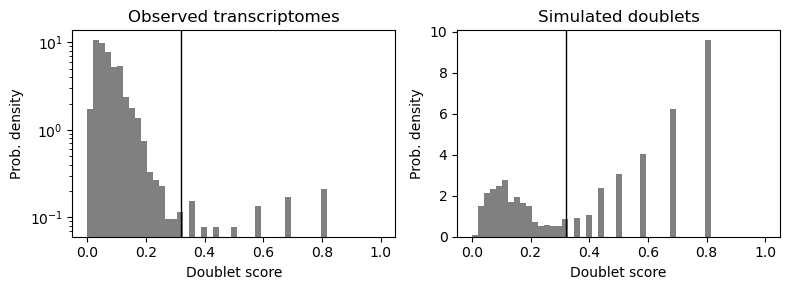

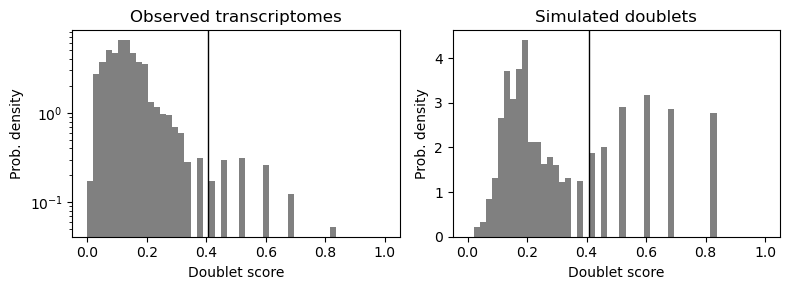

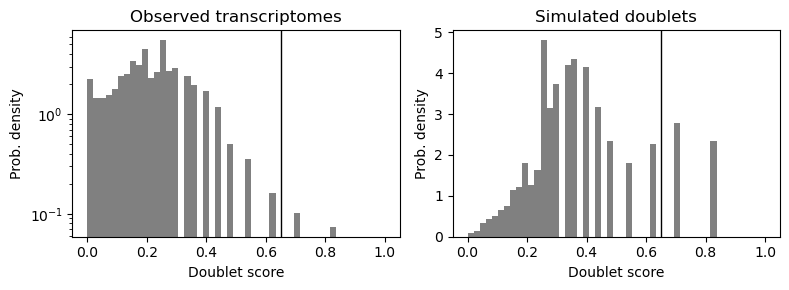

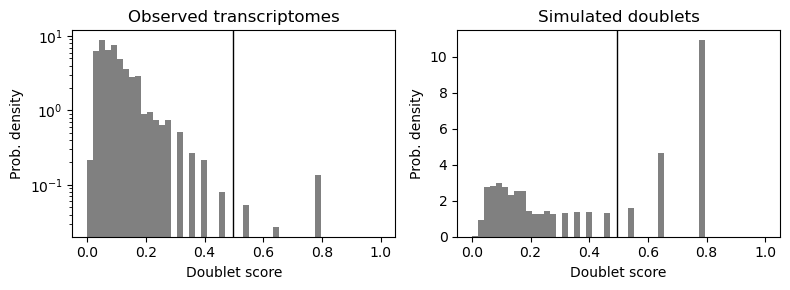

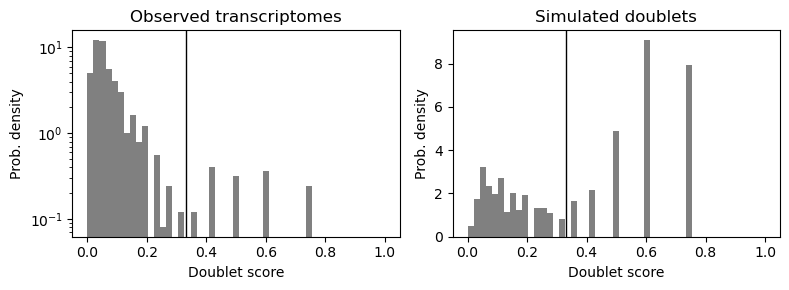

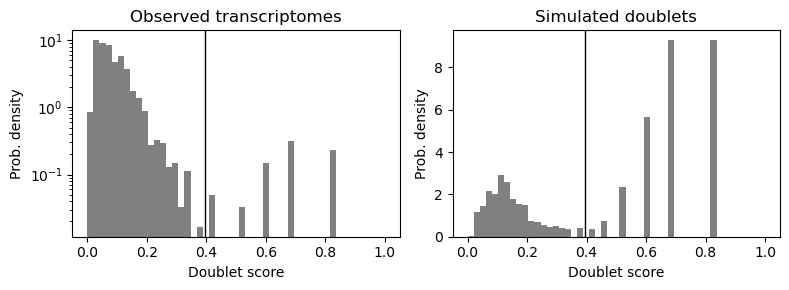

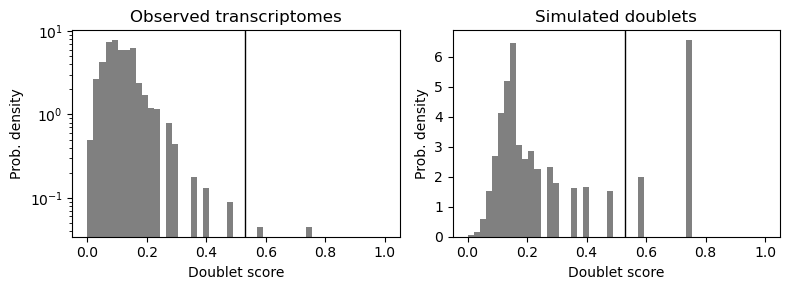

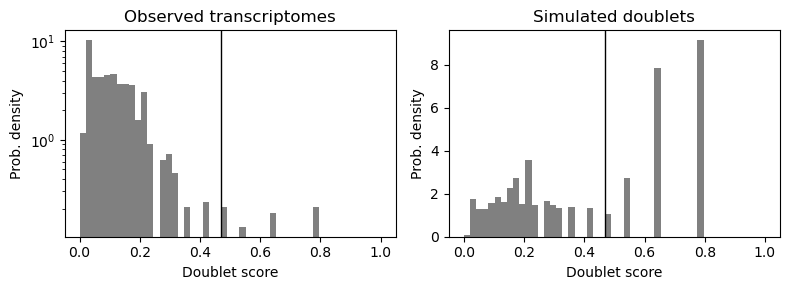

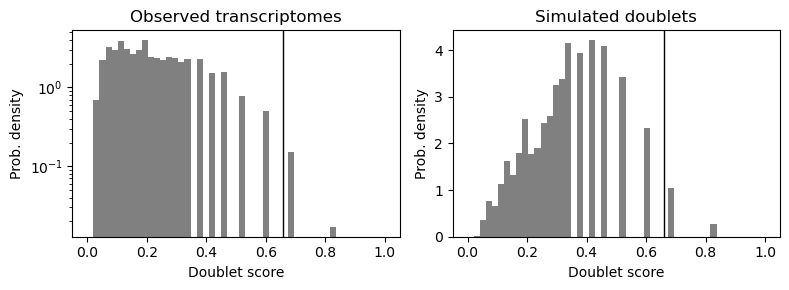

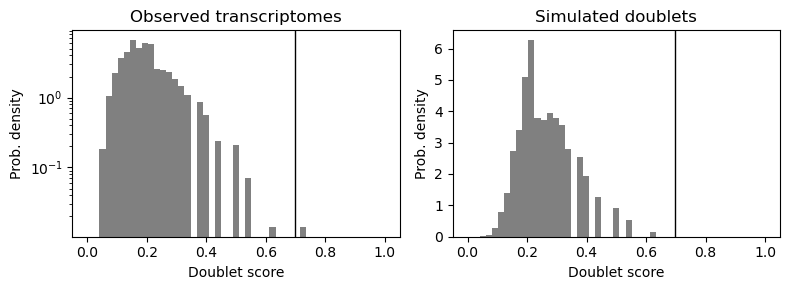

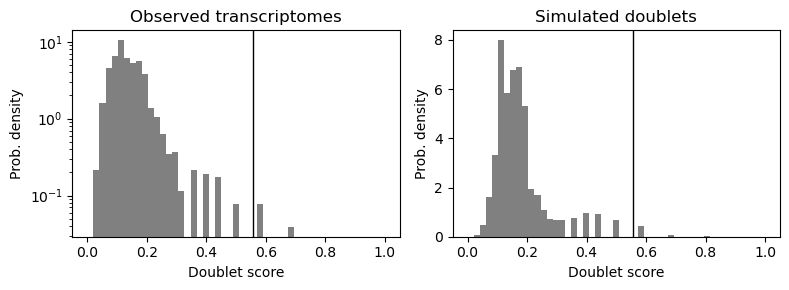

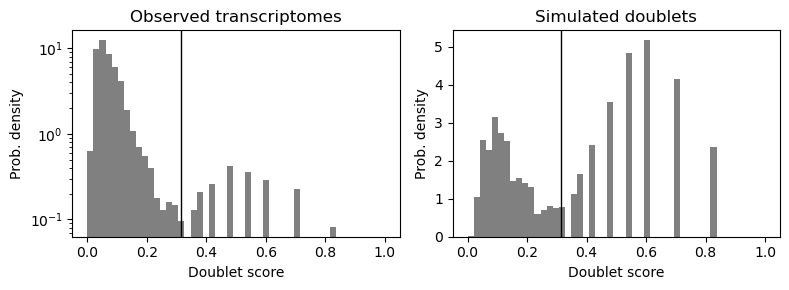

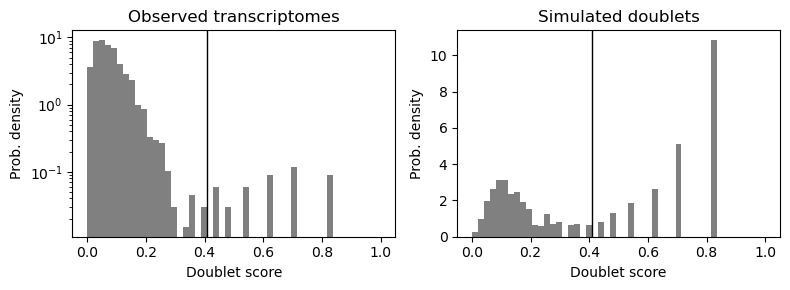

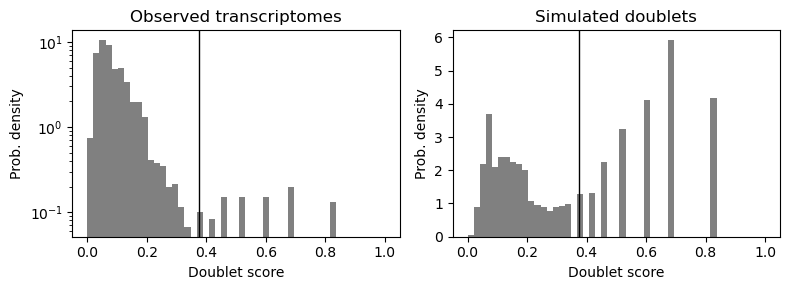

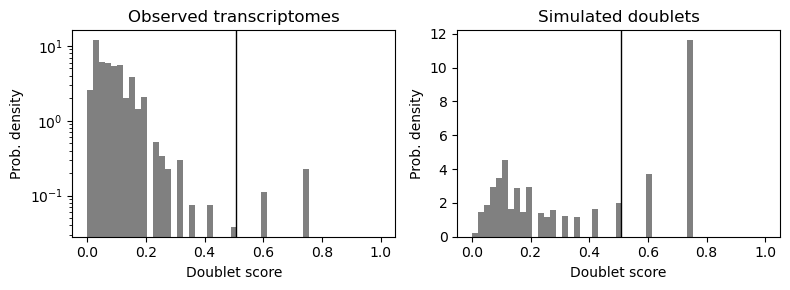

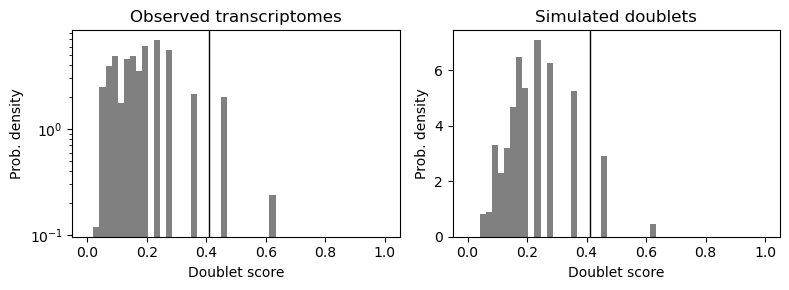

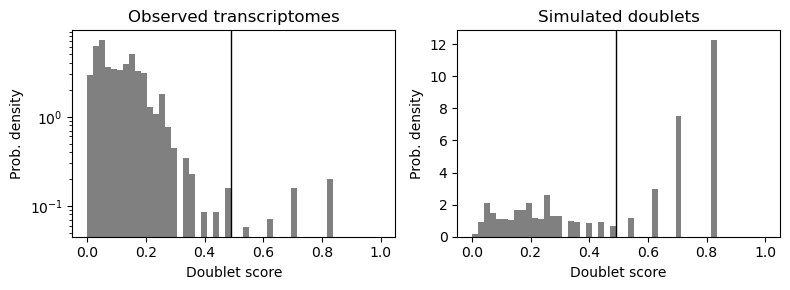

In [21]:
import scrublet as scr
for i, adata in enumerate(adata_list):
    try:
        # Scrublet 객체 생성
        scrub = scr.Scrublet(adata.X)
        
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
        
        adata.obs['doublet_scores'] = doublet_scores
        adata.obs['predicted_doublets'] = predicted_doublets
        
        print(f"Processed adata {i + 1}/{len(adata_list)} successfully.")
        scrub.plot_histogram()
    except Exception as e:
        print(f"Error in processing adata {i + 1}/{len(adata_list)}: {e}")
        # adata.obs의 doublet_scores와 predicted_doublets에 모두 NA를 설정
        adata.obs['doublet_scores'] = pd.Series([np.nan] * adata.shape[0])
        adata.obs['predicted_doublets'] = pd.Series([np.nan] * adata.shape[0])
        continue

del scrub, doublet_scores, predicted_doublets
# 3m 36s for 24 samples
# 2m 47s for 24 samples
# 1m 24.9s for Normalized, log scaled 24 samples

# 4m 48s for 95 samples ~250k cells

In [22]:
# visualize and FILTER the doublets <- 돌려야 함.
for i in range(len(adata_list)):
    # visualize the doublets
    # sc.pp.pca(adata_list[i])
    # sc.pp.neighbors(adata_list[i])
    # sc.tl.umap(adata_list[i])
    # sc.pl.umap(adata_list[i], color=['doublet_scores', 'predicted_doublets'])
    
    # filter the doublets
    try:
        adata_list[i] = adata_list[i][~adata_list[i].obs['predicted_doublets'], :]
    except Exception as e:
        continue
del i

In [23]:
# 세포가 1개 이상인 샘플만 남기기
adata_list = [adata for adata in adata_list if adata.n_obs > 0]
len(adata_list)

70

In [24]:
# 각 adata의 n_obs 값을 확인하고, 그 중 최솟값을 구함
n_obs_list = [adata.n_obs for adata in adata_list]
min_n_obs = min(n_obs_list)

print(f"The minimum n_obs in adata_list is {min_n_obs}.")

The minimum n_obs in adata_list is 153.


# Normalization and log scale the data
> Scrublet으로 doublet 제거하기 전에 하면 Pt23 샘플에서 오류남. 이유는 모르고 predicted_doublet에 None이 저장됨.

In [25]:
for adata in adata_list:
    sc.pp.normalize_total(adata, target_sum = 1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\heung\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  vi

# Merge the data

In [26]:
adata = sc.concat(adata_list, join = 'outer', label = 'sample', keys = [adata.obs['sample'].unique()[0] for adata in adata_list])
adata.obs.drop(columns=['n_genes_by_counts', 'predicted_doublets', 'doublet_scores'], inplace=True)

adata.obs_names_make_unique()

# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# preserve the raw data
adata.layers['counts'] = adata.X.copy() # scVI use this data

c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['GGGAGTAGTTGCTTGA-1', 'GTCGAATGTACCTAGT-1']
  warnings.warn(


# Save the merged adata

In [27]:

adata.write_h5ad(folder_path + '\\preprocessed_adata.h5ad')